# Implement K-means and K-means++
We see that the scikit-learn version centers the data to get more accurate distance computations, so we do so also.

https://github.com/scikit-learn/scikit-learn/blob/c957249/sklearn/cluster/k_means_.py#L295

mykmeans (array([[ 4.55833333,  3.075     ,  1.31666667,  0.20833333],
       [ 4.97727273,  3.31363636,  1.50454545,  0.23636364],
       [ 5.38125   ,  3.81875   ,  1.51875   ,  0.28125   ]]), 5.96)

Time: 0.0277960300446

mykmeans_multi (array([[ 4.55833333,  3.075     ,  1.31666667,  0.20833333],
       [ 4.97727273,  3.31363636,  1.50454545,  0.23636364],
       [ 5.38125   ,  3.81875   ,  1.51875   ,  0.28125   ]]), 5.96)

Time: 1.6231918335

mykmeans_pp (array([[ 4.69      ,  3.085     ,  1.385     ,  0.19      ],
       [ 5.51111111,  3.94444444,  1.45555556,  0.26666667],
       [ 5.09047619,  3.50952381,  1.54285714,  0.28571429]]), 5.553666666666668)

Time: 0.0107109546661

mykmeans_multi w/pp [[ 4.69        3.085       1.385       0.19      ]
 [ 5.12173913  3.5173913   1.53043478  0.27826087]
 [ 5.52857143  4.04285714  1.47142857  0.28571429]] 5.52128571429 False

Time: 1.02419018745

mykmeans_multi w/pp [[ 5.12173913  3.5173913   1.53043478  0.27826087]
 [ 4.69        3.08

/Users/mich/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/mich/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


 [[ 5.52857143  4.04285714  1.47142857  0.28571429]
 [ 5.12173913  3.5173913   1.53043478  0.27826087]
 [ 4.69        3.085       1.385       0.19      ]] 5.52128571429

Time: 0.127104043961
[[-0.1590038   0.04411941]
 [ 0.46701992 -0.0285708 ]
 [-0.81190157 -0.06333292]]
[[-0.81190157 -0.06333292]
 [-0.1590038   0.04411941]
 [ 0.46701992 -0.0285708 ]]


<IPython.core.display.Javascript object>


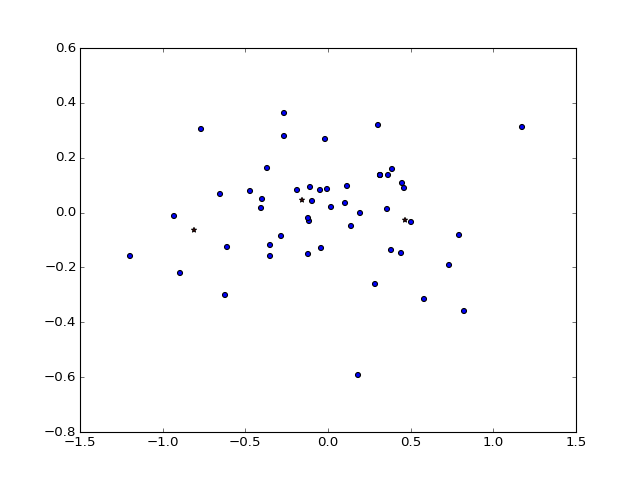

In [1]:
from sklearn.datasets import make_regression
from sklearn.cross_validation import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import sys
import numpy as np
from numpy.linalg import norm 
import random
import math
import time 


def get_buckets_of_samples(p,centroids):
    C=[] # to hold samples near each centroid
    for i in range(len(centroids)):
        C.append([])

    # for each sample
    for i in range(len(p)):

        # find nearest centroid
        nearest_centroid = 0
        for j in range(1,len(centroids)):
            if norm(p[i]-centroids[j]) < \
                        norm(p[i]-centroids[nearest_centroid]):
                nearest_centroid = j

        C[nearest_centroid].append(i) # add sample's index to cluster
    assert len(C) > 0
    return C


def mykmeans(p,k,iter,centroids=None):
    y = np.zeros(len(p))
    if centroids == None:
        centroids = train_test_split(p.copy(), y, train_size=k, 
                                     random_state=10051999)[0]
    tol = 0.000001
    movement = tol + 1
    counter = 0
    err = 0
    while movement > tol and counter < iter:
        counter += 1
        
        # assign sample to cluster
        C = get_buckets_of_samples(p,centroids)
        assert len(C) > 0
    
        movement = 0.0
        for i in range(k):
            if len(C[i]) > 0:
                cluster_sum = np.zeros(p[0].shape)
                for j in range(len(C[i])):
                    cluster_sum += p[C[i][j]]
                movement += norm(centroids[i] - (cluster_sum / len(C[i])))
                centroids[i] = cluster_sum / len(C[i])
            else: # orphan cluster with no samples
                centroids[i] = p[random.randint(0, len(p)-1)]
            
        err = 0
        for i in range(k):
            for j in range(len(C[i])):
                err += math.pow(norm(centroids[i]-p[C[i][j]]),2)
                
        if iter == counter:
            print 'WARNING: Ran out of iterations'
    return (centroids, err)


def mykmeans_pp(p,k,iter):
    centroids = []
    centroids.append(p[random.randint(0, len(p)-1)])

    for centroid_counter in range(1,k):
        
        # assign sample to cluster
        C = get_buckets_of_samples(p,centroids)
        
        # construct probability distribution space
        denomin = 0.0
        for i in range(len(C)):
            for j in range(len(C[i])):
                denomin += math.pow(norm(centroids[i]-p[C[i][j]]),2)

        prob_range = 0.0
        for i in range(len(C)):
            for j in range(len(C[i])):
                prob_range += \
                        math.pow(norm(centroids[i]-p[C[i][j]]),2)/denomin
        prob_range_max = prob_range
        
        # make random draw
        random_point = random.uniform(0, prob_range_max)
        
        assert len(centroids)==centroid_counter

        # map back to sample
        prob_range = 0.0
        done = False
        for i in range(len(C)):
            if done == False:
                for j in range(len(C[i])):
                    prob_range += \
                            math.pow(norm(centroids[i]-p[C[i][j]]),2)/denomin
                    if random_point < prob_range:
                        centroids.append(p[C[i][j]])
                        done = True
                        break
                    if random_point >= prob_range and i==len(C)-1 and j==len(C[i])-1:
                        print 'ERROR',random_point, prob_range_max, prob_range
                        
        assert len(centroids)==centroid_counter+1
        
    assert len(centroids) == k

    return mykmeans(p,k,iter,np.asarray(centroids))


def mykmeans_multi(p,k,iter,rep,method=None,center=False):
    if center:
        p_mean = p.mean(axis=0)
        p -= p_mean
    runs = []
    errs = []
    for r in range(rep):
        if method == '++':
            run = mykmeans_pp(p,k,iter)
            centroids = run[0]
            err = run[1]
        else:
            run = mykmeans(p,k,iter)
            centroids = run[0]
            err = run[1]

        if center:
            centroids += p_mean
        runs.append(centroids)
        errs.append(err)
    return (runs[np.argmin(errs)], errs[np.argmin(errs)])


# load iris data
iris = load_iris()
X = iris.data
y = iris.target

# select particular class per assignment instructions
X_temp=[]
for i in range(len(y)):
    if y[i] == 0:
        X_temp.append(X[i])
X = np.asarray(X_temp)

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

k=3
max_iter=50
rep=100

start = time.time()
print 'mykmeans',mykmeans(X.copy(),k,max_iter)
print
end = time.time()
print 'Time:', end - start
print

start = time.time()
print 'mykmeans_multi',mykmeans_multi(X.copy(),k,max_iter,rep)
print
end = time.time()
print 'Time:', end - start
print

start = time.time()
print 'mykmeans_pp',mykmeans_pp(X.copy(),k,max_iter)
print
end = time.time()
print 'Time:', end - start
print

for center in [False, True]: # try both centered and non-centered data
    start = time.time()
    (centroid_list,err) = mykmeans_multi(X.copy(),k,max_iter,rep,method='++',
                                         center=center)
    print 'mykmeans_multi w/pp', centroid_list, err, center
    print
    end = time.time()
    print 'Time:', end - start
    print

# base line
start = time.time()
km = KMeans(n_clusters=k,max_iter=max_iter,n_init=rep,n_jobs=1)
km.fit(X.copy())
end = time.time()

# check accuracy of scikit learn

# assign sample to cluster
C = get_buckets_of_samples(X.copy(),km.cluster_centers_)
assert len(C) == k
err = 0
for i in range(k):
    for j in range(len(C[i])):
        err += math.pow(norm(km.cluster_centers_[i]-X[C[i][j]]),2)

print 'KMeans',km.cluster_centers_, err
print
print 'Time:', end - start

%matplotlib nbagg
centroid_list_2d = pca.transform(centroid_list)
print centroid_list_2d

print pca.transform(km.cluster_centers_)

plt.scatter(X_2d[:,0],X_2d[:,1])
for i in range(k):
    plt.scatter(centroid_list_2d[i,0],centroid_list_2d[i,1],c='r',marker='*')


# Bag-of-features

## Working With Text Data
See: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

- ## KNeighborsClassifier
Here we predict the category of news articles by training a nearest neighbor classifier.

In [2]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, 
                                  shuffle=True, random_state=42)

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier().fit(X_train_tfidf, twenty_train.target)
docs_new = ['God is love', 'OpenGL on the GPU is fast']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, twenty_train.target_names[category]))


'God is love' => soc.religion.christian
'OpenGL on the GPU is fast' => comp.graphics


- ## Sentiment Analysis on movie reviews
Here we predict the sentiment of movie reviews by a training naive Bayes classifier. See: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#exercise-2-sentiment-analysis-on-movie-reviews

In [ ]:
import sys
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import load_files
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

%matplotlib nbagg

movie_reviews_data_folder = 'txt_sentoken/'
dataset = load_files(movie_reviews_data_folder, shuffle=False)

# split the dataset in training and test set:
docs_train, docs_test, y_train, y_test = train_test_split(
        dataset.data, dataset.target, test_size=0.50, random_state=8349)


from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(min_df=.1,max_df=.9)),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
                    ])

parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=2)
gs_clf = gs_clf.fit(docs_train, y_train)
for element in gs_clf.grid_scores_:
    print element

y_predicted = gs_clf.predict(docs_test)

# Print the classification report
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=dataset.target_names))

# Print and plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

import matplotlib.pyplot as plt
plt.matshow(cm)
plt.show()


# Bag-of-Features
We consider local features on the Newsgroup dataset. We use Bag of Words for each sample and then train Word2Vec from training data to get vectors from words. Then we cluster those vectors. 

To find the Bag of Features on unseen samples, we take the Bag of Words and use Word2Vec to convert to vectors. Then we find the nearest centroid for each vectorized word. The most common centroid then predicts the classification of the unseen sample.

Note: Scikit-learn KMeans is much faster than our implementation however both converge to about the same error rate. If we used sparse matrices or Cython, we could also speed up our implementation.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.word2vec import Word2Vec
from sklearn.cluster import KMeans
import re, copy, time

def learnvocabulary(data_orig):
    # Clean data
    data = copy.deepcopy(data_orig)
    for i in range(len(data)):
        data[i] = re.sub("[^a-zA-Z]"," ", data[i])
        data[i] = data[i].lower().split()
        
    # Create Model to Convert to Words to Vectors
    start = time.time()
    w2v_model = Word2Vec(data,workers=4)
    w2v_model.init_sims(replace=True) # use to reduce memory usage
    vocab_vectors = w2v_model.syn0
    end = time.time()
    print 'Word2Vec Time:', end - start

    # Create KMeans model to cluster word vectors
    k=10
    max_iter=9999999
    rep=5
    
    start = time.time()
    (centroid_list,err) = mykmeans_multi(vocab_vectors.copy(), k, max_iter,
                                         rep, method='++', center=True)
    end = time.time()
    print 'mykmeans_multi w/pp Time:', end - start
    print 'mykmeans_multi w/pp err:', err
    
    km = KMeans(n_clusters=k)
    km.cluster_centers_ = centroid_list


# Baseline    
#     start = time.time()
#     km = KMeans(n_clusters=k,n_init=rep,n_jobs=4)
#     km.fit(vocab_vectors)
#     end = time.time()
#     print 'KMeans Time:', end - start
#     # check accuracy of scikit learn
#     # assign sample to cluster
#     C = get_buckets_of_samples(vocab_vectors.copy(),km.cluster_centers_)
#     assert len(C) == k
#     err = 0
#     for i in range(k):
#         for j in range(len(C[i])):
#             err += math.pow(norm(km.cluster_centers_[i] - \
#                                  vocab_vectors[C[i][j]]),2)
#     print 'KMeans err:', err



    return w2v_model, km


def getbof(sample, w2v_model, kmeans_model):
    sample_copy = copy.deepcopy(sample)
    sample_copy = re.sub("[^a-zA-Z]"," ", sample_copy)
    sample_copy_split = sample_copy.lower().split()

    sample_vector = []
    for s in sample_copy_split:
        try:
            sample_vector.append(w2v_model[s])
        except KeyError: # Ignore unseen words
            pass
    
    # predict nearest feature for each word
    centroid_predictions = []
    for s in sample_vector:
        centroid_predictions.append(kmeans_model.predict(s))

    for i in range(len(centroid_predictions)):
        centroid_predictions[i] = \
                    kmeans_model.cluster_centers_[centroid_predictions[i]]
        
    return centroid_predictions
    
# Get data
twenty_train = fetch_20newsgroups(subset='train', categories = ['alt.atheism'],
                                  shuffle=True, random_state=9876)

# Get vocab via feature (word) centroids
w2v_model, kmeans_model = learnvocabulary(twenty_train.data)

# Get feature centroid for local features (centroid for each word)
bof = getbof(twenty_train.data[0], w2v_model, kmeans_model)
print bof


<!--bibtex

@Article{Joachims,
  Author    = {T. Joachims},
  Title     = {Training linear SVMs in linear time},
  Journal   = {ACM Conference on Knowledge Discovery and Data Mining (KDD)},
  year      = 2006,
}

@article{Papa2007,
  author = {Papa, David A. and Markov, Igor L.},
  journal = {Approximation algorithms and metaheuristics},
  pages = {1--38},
  title = {{Hypergraph partitioning and clustering}},
  url = {http://www.podload.org/pubs/book/part\_survey.pdf},
  year = {2007}
}
-->

# Random Features for Large-Scale Kernel Machines
http://www.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf
## Introduction
Kernel machines such as Support Vector Machines (SVM) operate on the kernel matrix (Gram matrix). The kernel matrix is composed of every combination of the transformed points' dot product. So the elements of the kernel matrix grow with the square of the data. Because of limited computational power, this limits the amount of data that can be use to train a generic kernel machine. However, linear Support Vector Machines and regularized regression operate on the covariance matrix instead of the kernel matrix. Linear SVMs can be trained in linear time [CITATION](#cite-Joachims). Proposed is a way to combine the advantages of the linear and nonlinear approaches. The data is mapped to random features in lower dimensional space and then a linear learning technique is applied. By the kernel trick, the kernel of samples x and y is just the dot product of a transformation of x and y.

Let $k$ be kernel that is a positive definite function and x, y corresponding to samples in $R^d$
$$ k(x,y) = \langle \phi(x), \phi(y) \rangle $$
Now define mapping $z : R^d \rightarrow R^D$ where D << d
With a linear kernel,
$$ k(z(x),z(y)) = \langle z(x), z(y) \rangle = z(x)^T z(y)$$
By a using randomized features transformation,
$k(x,y) \approx z(x)^T z(y)$.
Analytical and empirical results are shown.

When evaluating a sample against a kernel machine, we compute $f(x) = \sum^N_{i=1}c_i k(x_i,x)$, which requires $O(Nd)$. But, using a linear kernel and finding hyperplane $w$ in $R^D$, we compute $f(x) = w^Tz(x)$, which is only $O(D+d)$, using the proposed randomized feature maps.

# Random Binning Features

In [ ]:
import numpy as np
import math
from numpy.random import *
from numpy.linalg import norm


def kernel_Cauchy(x):
    ret = 1
    for d in range(len(x)):
        ret *= 2.0/(1+(x[d]**2))
    return ret


def kernel_Gaussian(x):
    return math.exp(-1.0/2*norm(x)**2)


def kernel_Laplacian(x):
    return math.exp(-1.0*norm(x, ord=1))


def z(x,P,dist_type):
    z=np.zeros(P)
    for p in range(1,P+1):
        d = len(x)
        # randomly pick u and delta
        if dist_type=='Laplacian':
            delta = gamma(2,size=1)
        elif dist_type=='Cauchy':
            delta = standard_cauchy(size=1)
        else:
            return 'Error'
        assert len(delta) == 1

        u = rand(1)*delta

        to_hash = np.ceil((x-u)/delta)
        z[p-1] = hash(to_hash.tostring())
    return math.sqrt(1.0/P)*z

a = np.asarray([1,2,3,4,5,6,7,8,9,10,11,12,13])
b = np.asarray([13,12,11,10,9,8,7,6,5,4,3,2,1])

print kernel_Cauchy(a-b)
print np.dot(z(a,12,'Cauchy'),z(b,12,'Cauchy'))
print

print kernel_Laplacian(a-b)
print np.dot(z(a,12,'Laplacian'),z(b,12,'Laplacian'))
print
